In [1]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from IPython.display import Image
from pydotplus import graph_from_dot_data
from sklearn import metrics

from sklearn.ensemble import RandomForestClassifier

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz

from statsmodels.stats.outliers_influence import variance_inflation_factor

from xgboost import XGBClassifier


pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 500)
plt.rcParams['figure.figsize'] = (30,30)

In [2]:
df = pd.read_csv('../data/df.csv')

/Users/Vittorio/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (47,48,49,50,52,53,54,55,56,57,58,59,60) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df

,Unnamed: 0,matchID,date,day_of_week,name,league,game_number,score,length_outs,day_night,park_id,attendance,length_minutes,line_score,at_bats,hits,doubles,triples,homeruns,rbi,sacrifice_hits,sacrifice_flies,hit_by_pitch,walks,intentional walks,...,errors,passed_balls,double_plays,triple_plays,hp_umpire_id,1b_umpire_id,2b_umpire_id,3b_umpire_id,manager_id,winning_pitcher_id,losing_pitcher_id,saving_pitcher_id,winning_rbi_batter_id,starting_pitcher_id,player_1_id,player_2_id,player_3_id,player_4_id,player_5_id,player_6_id,player_7_id,player_8_id,player_9_id,winning_team,winner
0,55,62,18710707,Fri,CH1,na,14,7,54.0,D,CHI01,5000.0,100.0,010040200,37.0,8.0,3.0,1.0,1.0,6.0,0.0,0.0,0.0,2.0,-1.0,...,4.0,0.0,0.0,0.0,hasts101,NaN,NaN,NaN,woodj106,zettg101,spala101,NaN,NaN,zettg101,duffe101,woodj106,treaf101,kingm101,mcatb101,simmj101,pinke101,hodec101,zettg101,Home,1.0
1,145,153,18720511,Sat,BL1,na,10,8,54.0,D,BAL02,20349.0,115.0,140000030,41.0,11.0,3.0,1.0,1.0,4.0,0.0,0.0,0.0,1.0,-1.0,...,4.0,0.0,0.0,0.0,bomet901,NaN,NaN,NaN,cravb101,mathb101,zettg101,NaN,NaN,mathb101,radcj101,cravb101,pikel101,fishc102,yorkt101,highd101,mille105,hallg101,mathb101,Home,1.0
2,182,191,18720615,Sat,PH1,na,12,11,54.0,D,PHI01,600.0,95.0,200042021,44.0,14.0,2.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,-1.0,...,5.0,0.0,1.0,0.0,mcleb901,NaN,NaN,NaN,mcbrd101,mcbrd101,britj103,NaN,NaN,mcbrd101,cuthn101,mcbrd101,meyel102,malof101,fislw101,treaf101,ansoc101,mcgem101,mackd101,Home,1.0
3,195,204,18720626,Wed,BL1,na,24,9,54.0,D,BAL02,20349.0,110.0,302000103,48.0,9.0,-1.0,-1.0,-1.0,5.0,0.0,0.0,0.0,0.0,-1.0,...,4.0,-1.0,-1.0,0.0,younn801,NaN,NaN,NaN,cravb101,mathb101,steab101,NaN,NaN,mathb101,radcj101,highd101,pikel101,yorkt101,fishc102,caret101,mille105,hallg101,mathb101,Home,1.0
4,204,213,18720704,Thu,NY2,na,23,20,54.0,D,NYC01,3000.0,140.0,40020(11)210,55.0,23.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,1.0,-1.0,...,3.0,0.0,0.0,0.0,kennj102,NaN,NaN,NaN,hatfj101,cummc101,woltr101,NaN,NaN,cummc101,eggld101,hatfj101,starj101,bechg101,hickn101,boydb101,mcmuj101,fulmc102,cummc101,Home,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
281773,140883,171901,20161002,Sun,CIN,NL,162,4,54.0,D,CIN09,32587.0,198.0,300100000,32.0,6.0,2.0,0.0,0.0,4.0,0.0,0.0,1.0,3.0,0.0,...,0.0,0.0,1.0,0.0,whitc901,belld901,morag901,hallt901,pricb801,grimj002,igler001,edwac001,szczm001,stepr002,peraj003,dejei002,vottj001,duvaa001,sches001,suare001,barnt001,rendt001,stepr002,Visitor,0.0
281774,140884,171902,20161002,Sun,COL,NL,162,4,60.0,D,DEN02,27762.0,203.0,1100100010,41.0,13.0,4.0,0.0,1.0,4.0,1.0,0.0,1.0,3.0,0.0,...,0.0,0.0,0.0,0.0,barrs901,woodt901,randt901,ortir901,weisw001,thort001,rusic001,knebc001,susaa001,marqg001,blacc001,dahld001,arenn001,gonzc001,murpt002,pattj005,valap001,adamc001,marqg001,Visitor,0.0
281775,140885,171903,20161002,Sun,PHI,NL,162,5,51.0,D,PHI13,36935.0,159.0,00100031x,33.0,10.0,1.0,0.0,0.0,3.0,0.0,1.0,0.0,2.0,0.0,...,0.0,0.0,1.0,0.0,barkl901,herna901,barrt901,littw901,mackp101,murrc002,goede001,nerih001,hernc005,eickj001,hernc005,parej002,herro001,franm004,howar001,ruppc001,blana001,altha001,eickj001,Visitor,0.0
281776,140887,171905,20161002,Sun,SLN,NL,162,10,51.0,D,STL10,44615.0,192.0,00100360x,36.0,12.0,2.0,0.0,1.0,10.0,0.0,2.0,0.0,4.0,0.0,...,0.0,0.0,1.0,0.0,cuzzp901,ticht901,vanol901,marqa901,mathm001,broxj001,nicaj001,NaN,piscs001,waina001,carpm002,diaza003,moliy001,piscs001,peraj001,mossb001,gyorj001,gricr001,waina001,Visitor,0.0


In [4]:
for column in df.columns:
    if '_id' in column:
        df.drop(columns=column, inplace=True)

In [5]:
df = df.fillna(0)

In [6]:
# feature selection
y = df['winner']
X = df.drop(columns=['Unnamed: 0', 'matchID', 'winner', 'league', 'score', 'winning_team', 'line_score', 'name', 'day_night'])

In [7]:
# Preparing the data for the VIF analysis
day = X['day_of_week'].str.get_dummies()
X = X.join(day)
X.drop(columns=['day_of_week'], inplace=True)

In [8]:
Xvif = X.loc[:, :'triple_plays']

In [9]:
# from statsmodels.stats.outliers_influence import variance_inflation_factor
# vif = [variance_inflation_factor(Xvif.values, i) for i in range(Xvif.shape[1])]
# list(zip(Xvif.columns, vif))

In [10]:
y = df['winner']
# Columns dropped after VIF analysis:
X.drop(columns=['length_outs', 'at_bats', 'putouts'], inplace=True)

In [11]:
# Decision tree to identify important features
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    random_state=42
                                                   )

X_train, X_validate, y_train, y_validate = train_test_split(X_train,
                                                           y_train,
                                                           test_size=0.3,
                                                           random_state=42
                                                           )

# Initialising K-Folds
kfold = KFold(n_splits=5,
              random_state=42,
              shuffle=True
             )

In [12]:
# Train Decision tree
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

DecisionTreeClassifier()

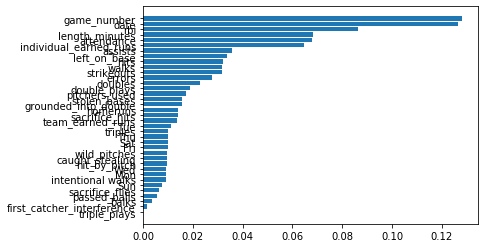

In [13]:
features = X_train.columns
importances = clf.feature_importances_
indices = np.argsort(importances)

plt.barh(range(len(indices)),importances[indices], align='center');
plt.yticks(range(len(indices)), [features[i] for i in indices]);

In [14]:
# logistic regression as baseline model
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_validate_s = scaler.transform(X_validate)

logreg = LogisticRegression(fit_intercept=False, C=1e12, solver='liblinear')
model_log = logreg.fit(X_train_s, y_train)
model_log

LogisticRegression(C=1000000000000.0, fit_intercept=False, solver='liblinear')

In [15]:
# ROC_AUC of the folds
cross_val_score(logreg, X_train_s, y_train, scoring='roc_auc', cv=kfold)

array([0.59252671, 0.59919449, 0.59291932, 0.59899295, 0.59309701])

In [16]:
# AUC score of train vs validate
y_score = logreg.fit(X_train_s, y_train).decision_function(X_validate_s)

fpr, tpr, thresholds = roc_curve(y_validate, y_score)
print('AUC: {}'.format(auc(fpr, tpr)))

AUC: 0.5942847890087066


In [17]:
# Initial hyperparameter ranges for the Decision Tree
# param_grid = {'criterion' : ['gini','entropy'],
#               'max_depth' : [x for x in range(2,10)],
#               'min_samples_leaf' : [x for x in range(500,5000,500)]
#              }

# Output
# criterion: entropy
# max_depth: 9
# min_samples_leaf: 500
# accuracy: 0.64583

# Second round
# param_grid = {'criterion' : ['gini','entropy'],
#               'max_depth' : [x for x in range(7,20)],
#               'min_samples_leaf' : [x for x in range(100,1000,100)]
#              }

# Output
# criterion: gini
# max_depth: 1
# min_samples_leaf: 400
# ROC_AUC: 0.72065

param_grid = {'criterion' : ['gini','entropy'],
              'max_depth' : [x for x in range(7,20)],
              'min_samples_leaf' : [x for x in range(100,500,100)]
             }
dtree = DecisionTreeClassifier()

In [18]:
grid = GridSearchCV(estimator = dtree, 
                    param_grid = param_grid, 
                    scoring = 'roc_auc',
                    cv = kfold,
                    n_jobs = -1,
                    return_train_score=True
                   )

In [19]:
# grid = grid.fit(X_train, y_train)
# criterion = grid.best_params_['criterion']
# max_depth = grid.best_params_['max_depth']
# min_samples_leaf = grid.best_params_['min_samples_leaf']
# print(f'criterion: {criterion}')
# print(f'max_depth: {round(max_depth,5)}')
# print(f'min_samples_leaf: {round(min_samples_leaf,5)}')
# print(f'ROC_AUC: {round(grid.best_score_,5)}')

# Output
# criterion: gini
# max_depth: 13
# min_samples_leaf: 300
# ROC_AUC: 0.68201


In [20]:
clf = DecisionTreeClassifier(criterion='entropy', max_depth=13, min_samples_leaf=400)
clf.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=13, min_samples_leaf=400)

In [21]:
y_score = clf.predict_proba(X_validate)
fpr, tpr, thresholds = roc_curve(y_validate, [y_score[x][1] for x in range(len(y_score))])
print('AUC: {}'.format(auc(fpr, tpr)))

AUC: 0.6843641549312702


In [22]:
# Graphical representation of the decision tree

# export_graphviz(clf,
#                 out_file='tree.dot', 
#                 feature_names=X_train.columns,  
#                 class_names=np.unique(y).astype('str'), 
#                 filled=True,
#                 rounded=True,
#                 special_characters=True,
#                 precision = 2
#                 )

In [23]:
# from subprocess import Popen, PIPE
# Popen('dot -Tpng tree.dot -o tree.png -Gdpi=600', shell=True, stdout=PIPE, stderr=PIPE)

In [24]:
# First round of GridSearchCV for Random Forest
# param_grid = {'criterion' : ['gini','entropy'],
#               'max_depth' : [x for x in range(2,10)],
#               'min_samples_leaf' : [x for x in range(100,1000,100)],
#              }

# Output
# criterion: gini
# max_depth: 9
# min_samples_leaf: 100
# ROC_AUC: 0.72108

# param_grid = {'max_depth' : [x for x in range(8,15)],
#               'min_samples_leaf' : [x for x in range(10,200,10)]
#              }
# rfc = RandomForestClassifier()

In [25]:
# grid = GridSearchCV(estimator = dtree, 
#                     param_grid = param_grid, 
#                     scoring = 'roc_auc',
#                     cv = kfold,
#                     n_jobs = -1,
#                     return_train_score=True
#                    )

In [26]:
# grid = grid.fit(X_train, y_train)
# max_depth = grid.best_params_['max_depth']
# min_samples_leaf = grid.best_params_['min_samples_leaf']
# print(f'max_depth: {round(max_depth,5)}')
# print(f'min_samples_leaf: {round(min_samples_leaf,5)}')
# print(f'ROC_AUC: {round(grid.best_score_,5)}')

# Output
# max_depth: 9
# min_samples_leaf: 100
# ROC_AUC: 0.68173


In [27]:
rfc = RandomForestClassifier(max_depth=14, min_samples_leaf=10)
rfc.fit(X_train, y_train)

RandomForestClassifier(max_depth=14, min_samples_leaf=10)

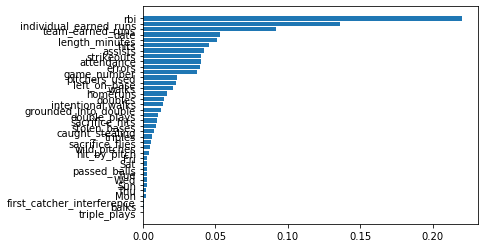

In [28]:
features = X_train.columns
importances = rfc.feature_importances_
indices = np.argsort(importances)

plt.barh(range(len(indices)),importances[indices], align='center');
plt.yticks(range(len(indices)), [features[i] for i in indices]);

In [29]:
# Define function to build ROC curve for XGBoost
def buildROC(target_train, train_preds, target_test,test_preds):
    fpr, tpr, threshold = metrics.roc_curve(target_test, test_preds)
    roc_auc = metrics.auc(fpr, tpr)
    fpr1, tpr1, threshold = metrics.roc_curve(target_train, train_preds)
    roc_auc1 = metrics.auc(fpr1, tpr1)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr1, tpr1, 'b', label = 'Train AUC = %0.2f' % roc_auc1)
    plt.plot(fpr, tpr, 'b', label = 'Validation AUC = %0.2f' % roc_auc, color = 'g')
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.gcf().savefig('roc.png')

In [30]:
# Instantiate XGBoost & Fit Train Data
clf = XGBClassifier()
clf.fit(X_train, y_train)

XGBClassifier()

In [31]:
# Predict for Train & Validation Data
training_preds = clf.predict(X_train)
validate_preds = clf.predict(X_validate)

# Calculate Accuracy for Train & Validation Data
training_roc_auc = roc_auc_score(y_train, training_preds)
validate_roc_auc = roc_auc_score(y_validate, validate_preds)

print('Training ROC_AUC: {:.4}%'.format(training_roc_auc * 100))
print('Validation ROC_AUC: {:.4}%'.format(validate_roc_auc * 100))

Training ROC_AUC: 62.11%
Validation ROC_AUC: 61.48%


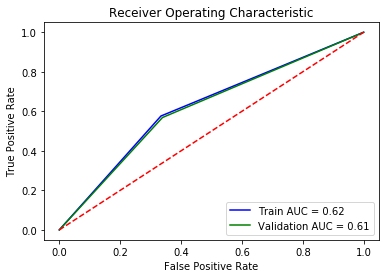

In [32]:
buildROC(y_train, training_preds, y_validate, validate_preds)

In [33]:
param_grid = {
    'learning_rate': [0.05, 0.1, 0.25, 0.5],
    'max_depth': [5, 8, 10, 13],
    'min_child_weight': [0.1, 0.5, 1.0],
    'subsample': [1.0],
    'n_estimators': [100],
}

In [38]:
# grid_clf = GridSearchCV(clf, param_grid, scoring='roc_auc', cv=kfold, n_jobs=-1)
# grid_clf.fit(X_train, y_train)

# best_parameters = grid_clf.best_params_

# print('Grid Search found the following optimal parameters: ')
# for param_name in sorted(best_parameters.keys()):
#     print('%s: %r' % (param_name, best_parameters[param_name]))

# training_preds = grid_clf.predict(X_train)
# validate_preds = grid_clf.predict(X_validate)

# training_roc_auc = roc_auc_score(y_train, training_preds)
# validate_roc_auc = roc_auc_score(y_validate, validate_preds)

# print('Training ROC_AUC: {:.4}%'.format(training_roc_auc * 100))
# print('Validation ROC_AUC: {:.4}%'.format(validate_roc_auc * 100))

# Grid Search found the following optimal parameters: 
# learning_rate: 0.05
# max_depth: 8
# min_child_weight: 0.1
# n_estimators: 100
# subsample: 1.0
# Training ROC_AUC: 68.49%
# Validation ROC_AUC: 63.07%

# due to the excessive amount of time the optimization takes (~4h) we'll stick to the first round of optimization

In [35]:
y_train_score = rfc.predict_proba(X_train)
fpr, tpr, thresholds = roc_curve(y_train, [y_train_score[x][1] for x in range(len(y_train_score))])
print('AUC train dataset: {}'.format(auc(fpr, tpr)))

AUC train dataset: 0.8222752937363034


In [36]:
y_validate_score = rfc.predict_proba(X_validate)
fpr, tpr, thresholds = roc_curve(y_validate, [y_validate_score[x][1] for x in range(len(y_validate_score))])
print('AUC validation dataset: {}'.format(auc(fpr, tpr)))

AUC validation dataset: 0.6974191855169173


In [37]:
y_test_score = rfc.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, [y_test_score[x][1] for x in range(len(y_test_score))])
print('AUC test dataset: {}'.format(auc(fpr, tpr)))

AUC test dataset: 0.696201890623483


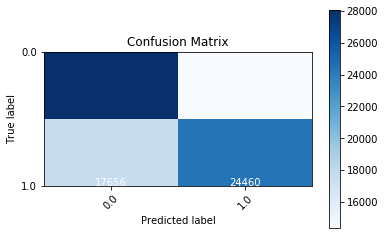

In [39]:
y_hat_test = rfc.predict(X_test)

cnf_matrix = confusion_matrix(y_test, y_hat_test)

# Create the basic matrix
plt.imshow(cnf_matrix,  cmap=plt.cm.Blues) 

plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Add appropriate axis scales
class_names = set(y) # Get class labels to add to matrix
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

# Add labels to each cell
thresh = cnf_matrix.max() / 2. # Used for text coloring below
# Here we iterate through the confusion matrix and append labels to our visualization 
for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, cnf_matrix[i, j],
                 horizontalalignment='center',
                 color='white' if cnf_matrix[i, j] > thresh else 'black')

# Add a legend
plt.colorbar()
plt.show()

In [40]:
cm = {'TP': 0, 'TN': 0, 'FP': 0, 'FN': 0}
def conf_matrix(self,y_test, y_hat_test):
        for ind, label in enumerate(y_test):
            pred = y_hat_test[ind]
            if label == 1: 
                if label == pred:
                    cm['TP'] += 1
                else:
                    cm['FN'] += 1
            else:
                if label == pred:
                    cm['TN'] += 1
                else:
                    cm['FP'] += 1
            self.cm_values = cm
        return cm

In [41]:
conf_matrix(rfc,y_test,y_hat_test)

{'TP': 24460, 'TN': 28039, 'FP': 14379, 'FN': 17656}